# Предсказание стоимости жилья


**Описание проекта**


Необходимо обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. На основе данных предсказать медианную стоимость дома в жилом массиве. Обучить модель и сделать предсказания на тестовой выборке. Для оценки качества модели использовать метрики RMSE, MAE и R2.

# План по выполнению проекта

1. Инициализация локальной Spark-сессии
2. Загрузка данных
3. Предобработка и исследовательский анализ данных
4. Проверка на мультиколлинеарность
5. Отбор набора обучающих признаков
6. Обучение моделей
7. Итоговая оценка качества предсказания лучшей модели
8. Анализ результатов
9. Отчет по исследованию

# Описание данных

**Данные:**

- **/datasets/housing.csv** - данные о жилье в Калифорнии в 1990 году
- **median_house_value** — целевой признак, медианная стоимость дома в жилом массиве

**Описание полей данных:**

- **longitude** — широта;
- **latitud**e — долгота;
- **housing_median_age** — средний возраст дома в пределах живого массива; меньшее число указывает на более новое здание;
- **total_rooms** — общее количество комнат в домах жилого массива;
- **total_bedrooms** — общее количество спален в домах жилого массива;
- **population** — количество человек, которые проживают в жилом массиве;
- **households** — количество домовладений в жилом массиве;
- **median_income** — медианный доход жителей жилого массива;
- **median_house_value** — медианная стоимость дома в жилом массиве;
- **ocean_proximity** — близость к океану.

## Инициализация локальной Spark-сессии

### Импорт библиотек

In [1]:
import warnings
warnings.filterwarnings('ignore')

#загрузка стандартных библиотек
import pandas as pd 
import numpy as np

#графики
import seaborn as sns
import matplotlib.pyplot as plt

#pyspark
import pyspark
from pyspark import SparkContext

#pyspark.sql
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import round, when, lit, col, sum as spark_sum

#ml.feature
from pyspark.ml.stat import Correlation
from pyspark.sql.types import DoubleType, IntegerType, StringType
from pyspark.ml.feature import Imputer

#создание ML 
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from pyspark import SparkContext

sc = SparkContext()
pyspark_version = sc.version

if int(pyspark_version[0]) == 3:
    from pyspark.ml.feature import OneHotEncoder  as OHE
elif int(pyspark_version[0]) == 2:
    from pyspark.ml.feature import OneHotEncodeEstimator as OHE

        
RANDOM_SEED = 12345

### Функции

In [2]:
#удаление признака из датафрейма

def del_column(exclude, data):
    '''
    exclude = cписок столбцов
    data = data
    '''
    selected_columns = [col for col in data.columns if col not in exclude]
    data = data.select(selected_columns)
    return data

In [3]:
#Информация о данных:

def data_info(data):
    '''
    1. тип данных колонок датасета
    2. первые пять строк датасета c полным выводом всех столбцов
    3. сводная статистика данных с округлением до 2х знаков после запятой
    '''
    print('тип данных колонок датасета:')
    data.printSchema() 
    pd.set_option('display.max_columns', None)  # Установка максимальной ширины столбцов
    pd.set_option('display.width', None)  # Установка максимальной ширины вывода
    pd.set_option('display.max_columns', None)
    print('первые пять строк датасета:')
    display(data.limit(5).toPandas())
    
    #сводная статистика данных
    
    summary = data.describe()
    #исключить столбец «summary»
    summary = del_column(['summary'], summary)
    #округление значений до двух знаков после запятой
    rounded_summary = summary.select(
    *[round(col(column), 2).alias(column) for column in summary.columns])
    display(rounded_summary.toPandas())
    
    #подсчет количества дубликатов
    duplicate_count = data.groupBy(data.columns).count().where(col('count') > 1).agg(spark_sum('count')).collect()[0][0]
    print('количество дубликатов в таблице:', duplicate_count)
    
    #создание диаграмм распределения
    
    # Получение списка столбцов
    columns = data.columns
    
    # Создание гистограммы распределения для каждого столбца с типом DoubleType
    columns = data.columns
    
    for column in columns:
        if isinstance(data.schema[column].dataType, DoubleType):
            column_data = data.select(column).dropna().rdd.flatMap(lambda x: x).collect()
        
            # Создание гистрограммы
            plt.figure(figsize=(10, 5))
            plt.hist(column_data, bins=100, color='skyblue', edgecolor='black')
        
            plt.xlabel(column)
            plt.ylabel('Количество')
            plt.title(f'Распределение {column}')
            
            plt.show()
            pass

In [4]:
#Построение диаграммы распределение с квантилями:

def plot_distrib(data, column_name):
    '''
    data = data
    column_name = 'column' - название выбранной колонки
    
    1. Выбор столбца из датасета
    2. Подсчет квантилей
    3. Построение гистограммы распределения
    '''

    # Выбор столбца из датасета
    column_data = data.sample(withReplacement=False, fraction=0.4, seed=RANDOM_SEED).select(column_name).rdd.flatMap(lambda x: x).collect()

    # Подсчет квантилей
    quantiles = data.sample(withReplacement=False, fraction=0.4, seed=RANDOM_SEED).approxQuantile(column_name, [0.25, 0.5, 0.75], 0)

    # Построение гистограммы распределения
    plt.figure(figsize=(15,5))
    plt.hist(column_data, bins=50, color='skyblue', edgecolor='black')

    # Добавление линий для квантилей
    plt.axvline(x=quantiles[0], color='red', linestyle='dashed', linewidth=2, label='0.25 квантиль')
    plt.axvline(x=quantiles[1], color='green', linestyle='dashed', linewidth=2, label='0.5 квантиль')
    plt.axvline(x=quantiles[2], color='blue', linestyle='dashed', linewidth=2, label='0.75 квантиль')

    # Настройка осей и заголовка
    plt.xlabel(column_name)
    plt.ylabel("Количество")
    plt.title(f"Распределение {column_name}")
    plt.legend()
    plt.show()
    pass
    print('0.25, 0.5 и 0.75 квантили:', quantiles)

In [5]:
#Построение диаграммы рассеивания
def plot_california_coast(data, column_name, fraction):
    
    '''
    data = data
    column_name = 'column' - название выбранной колонки
    
    1. Получение общей статистики с использованием сэмплирования
    2. Создание карты побережья Калифорнии
    3. Построение диаграммы рассеивания
    '''
    # Получение общей статистики с использованием сэмплирования
    sample_df = data.sample(withReplacement=False, fraction=0.4, seed=RANDOM_SEED) 

    # Создание карты побережья Калифорнии
    map_of_california = sample_df.select('longitude', 'latitude', column_name).toPandas()

    # Построение карты
    plt.figure(figsize=(15,8))
    sns.scatterplot(data=map_of_california, x='longitude', y='latitude', hue=column_name).set(title="Карта побережья Калифорнии")

    plt.show()
    pass

In [6]:
#Проверка на мультиколлинеарность признаков с помощью корреляции Cпирмена
def corr(columns, correlations):
    '''
    data = correlations
    columns = columns
    
    1. Удаление категориальной переменной "ocean_proximity" из датасета "correlations".
    2. С помощью VectorAssembler объединяются столбцы датасета "correlations" в один столбец "corr-features".
    3. Вычисляется корреляцию Спирмена для столбца "corr-features" с использованием функции Correlation.corr().
    4. Преобразование полученной матрицы корреляций в список.
    5. Создание нового датафрейма "df_corr" с использованием списков "corrmatrix" и "columns".
    6. Визуализация матрицы корреляций в виде тепловой карты с помощью библиотеки seaborn.
    '''
    
    #удаляю категориальную переменную 
    exclude = ['ocean_proximity']
    correlations = del_column(exclude, correlations)
    
    vector_col = 'corr-features'
    assembler = VectorAssembler(inputCols= correlations.columns, outputCol= vector_col)
    df_vector = assembler.transform(correlations).select(vector_col)
    
    #корреляция Спирмена 
    matrix = Correlation.corr(df_vector, vector_col, method="spearman").collect()[0][0]

    corrmatrix = matrix.toArray().tolist()
    
    #создаю датафрейм
    df_corr = spark.createDataFrame(corrmatrix, columns)

    fig, ax = plt.subplots(figsize=(15, 5))
    #тепловая карта
    sns.heatmap(df_corr.toPandas(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm')
    plt.title('Тепловая карта корреляций признаков')
    
    plt.show()
    pass

In [7]:
#Оценка качества модели

def pred(predictions, prediction):
    '''
    1. Оценка качества модели
    2. Расчет метрик
    3. Вывод результата
    '''
    # Оценка качества модели
    evaluator = RegressionEvaluator(labelCol=target[0], predictionCol="prediction", metricName="rmse")
    evaluator_mae = RegressionEvaluator(labelCol=target[0], predictionCol="prediction", metricName="mae")
    evaluator_r2 = RegressionEvaluator(labelCol=target[0], predictionCol="prediction", metricName="r2")

    # Оценка качества модели
    rmse = evaluator.evaluate(predictions)

    # Расчет метрик MAE и R2 на тестовых данных
    mae = evaluator_mae.evaluate(predictions)
    r2 = evaluator_r2.evaluate(predictions)

    # Вывод результата
    print("Root Mean Squared Error (RMSE) на тестовых данных = %g" % rmse)
    print("Mean Absolute Error (MAE) на тестовых данных = %g" % mae)
    print("R2 на тестовых данных = %g" % r2)

### Инициализация локальной Spark-сессии

In [8]:
# Переопределение параметров драйвера
conf = {
    'spark.driver.memory': '3g',
    'spark.driver.maxResultSize': '3g'
}

builder = SparkSession.builder

# Переопределение параметров драйвера
for k, v in conf.items():
    builder.config(k, v)

# Создание SparkSession с переопределенными параметрами драйвера
spark = builder.getOrCreate()

In [9]:
link = '/datasets/housing.csv'

while True:
    try:
        df_housing = spark.read.option('header', 'true').csv(link, inferSchema = True) 
        break
    except ValueError:
        print('Cсылка не действительна')

## Предобработка и исследовательский анализ данных

Исследуйте данные на наличие пропусков и заполните их, выбрав значения по своему усмотрению.
Преобразуйте колонку с категориальными значениями техникой One hot encoding.

тип данных колонок датасета:
root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)

первые пять строк датасета:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,20640.00,20640.00,20640.00,20640.00,20433.00,20640.00,20640.00,20640.00,20640.00,20640.0
1,-119.57,35.63,28.64,2635.76,537.87,1425.48,499.54,3.87,206855.82,NaN
2,2.00,2.14,12.59,2181.62,421.39,1132.46,382.33,1.90,115395.62,NaN
3,-124.35,32.54,1.00,2.00,1.00,3.00,1.00,0.50,14999.00,NaN
4,-114.31,41.95,52.00,39320.00,6445.00,35682.00,6082.00,15.00,500001.00,NaN


количество дубликатов в таблице: None


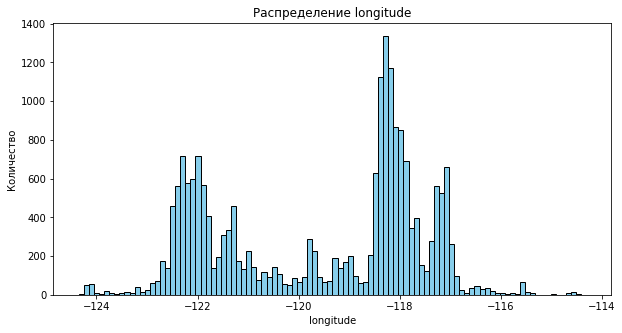

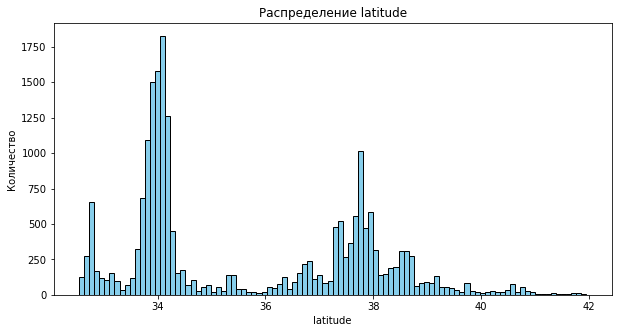

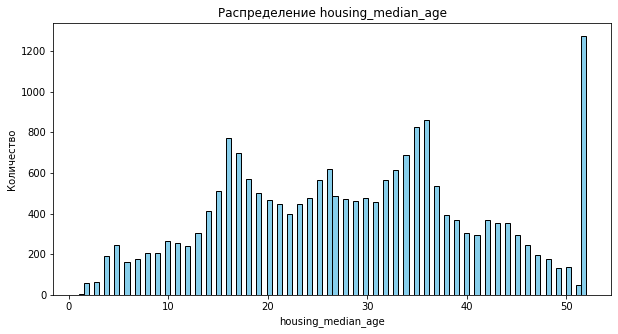

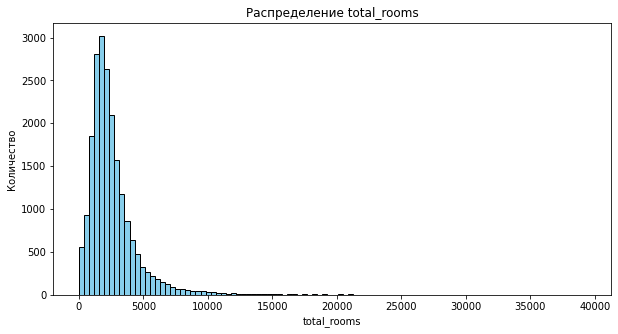

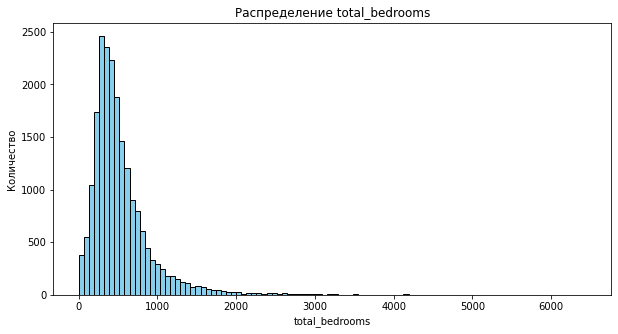

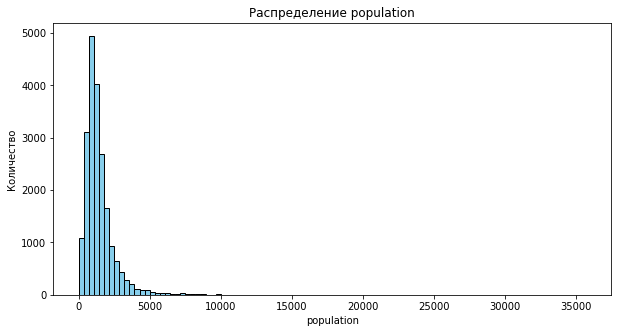

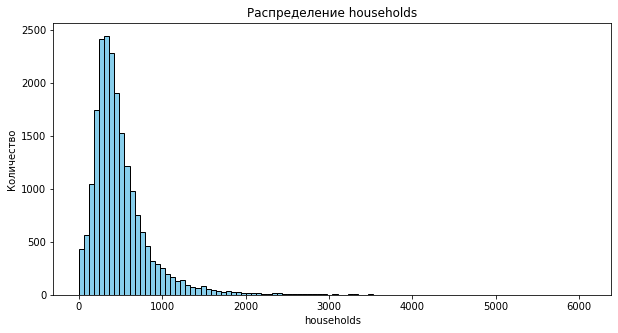

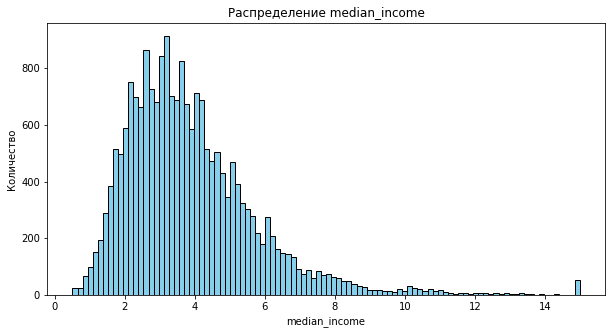

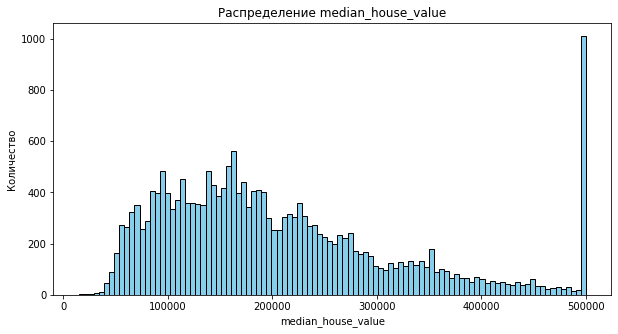

In [10]:
data_info(df_housing)

In [11]:
#5 самых распространенных уникальных значений медианного возраста домов живого массива
df_housing.groupBy('housing_median_age').count().orderBy('count', ascending = False).show(5)

+------------------+-----+
|housing_median_age|count|
+------------------+-----+
|              52.0| 1273|
|              36.0|  862|
|              35.0|  824|
|              16.0|  771|
|              17.0|  698|
+------------------+-----+
only showing top 5 rows



- Признак ocean_proximity (близость к океану) категориальный, остальные численные
- Для признаков housing_median_age, total_rooms, total_bedrooms,  population, households тип данных необходимо заменить на integer
- Широта в диапозоне от -124.35 до -114.31, долгота от 32.54 до 41.95
- Средний медианный возраст домов живого массива 29 лет
- Общее количество комнат колеблится в диапозоне от 2 до 39320. Следовательно, в данных присутствуют как частные дома, так и многоквартирные. Медианное значение 2127 комнат - в основном, дома многоквартирные. Аналогично, указывают на это данные об общем количестве спален, о количестве проживающих и домовладельцев.
- Медианный доход варируется от 0.5 до 15 десятков тысяч доларов 
- Медианная стоимость дома в жилом массиве в пределах 14.999-500.001 долларов, медианное значение 179.7

- По графикам распределенияя широты и долготы видно, что есть две густо населенные территории штата
- Медианный возраст домов жилого массива распределен нормально, за исключением трех доминирующих возрастов: около 16, 35 и 50 лет, вероятно, в те года были массовые застройки
- Общее количества комнат, спален, проживающих в жилом массиве и домовладельцев распределено практически экспоненциально со снижением распространенности по мере нарастания признака, что, в общем-то, естественно для данных значений
- В основном, медианная стоимость домов распределена нормально с перекосом вправо: по мере увеличения стоимости домов их количество уменьшается, но на пиковой стоимости резко возрастает

### Предобработка данных

Для признаков housing_median_age, total_rooms, total_bedrooms, population, households тип данных заменю на integer

In [12]:
df_housing = df_housing.withColumn('housing_median_age', F.col('housing_median_age').cast(IntegerType()))
df_housing = df_housing.withColumn('total_rooms', F.col('total_rooms').cast(IntegerType()))
df_housing = df_housing.withColumn('total_bedrooms', F.col('total_bedrooms').cast(IntegerType()))
df_housing = df_housing.withColumn('population', F.col('population').cast(IntegerType()))
df_housing = df_housing.withColumn('households', F.col('households').cast(IntegerType()))

df_housing.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: integer (nullable = true)
 |-- total_rooms: integer (nullable = true)
 |-- total_bedrooms: integer (nullable = true)
 |-- population: integer (nullable = true)
 |-- households: integer (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



**Пропуски в данных**

In [13]:
# вывод пропущенных значения в каждой колонке
columns = df_housing.columns

for column in columns:
    print(column, df_housing.where(F.isnan(column) | F.col(column).isNull()).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 207
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


In [14]:
#Процентное содержание пропусков в total_bedrooms
df_housing.where(F.isnan(column) | F.col('total_bedrooms').isNull()).count() * 100 / df_housing.select().count()

1.002906976744186

В датафрейме пропущен лишь 1% данных. В PySpark есть класс `Imputer`, который можно использовать для заполнения пропусков.

In [15]:
# Разделение данных на обучающую и тестовую выборки
train_df, test_df = df_housing.randomSplit([0.8, 0.2], seed=RANDOM_SEED)

imputer = Imputer(inputCols=['total_bedrooms'], outputCols=['total_bedrooms_imputed'])

# Обучение модели
imputer_model = imputer.fit(train_df)

# Применениек тестовой выборке
test_df_imputed = imputer_model.transform(test_df)

test_df_imputed.select('total_bedrooms', 'total_bedrooms_imputed').show(5)

+--------------+----------------------+
|total_bedrooms|total_bedrooms_imputed|
+--------------+----------------------+
|           394|                   394|
|          1056|                  1056|
|           634|                   634|
|           319|                   319|
|           178|                   178|
+--------------+----------------------+
only showing top 5 rows



In [16]:
# Применение модели к исходному датасету
df_housing = imputer_model.transform(df_housing)

# Удаление старого столбца total_bedrooms
df_housing = df_housing.drop('total_bedrooms')

# Переименование столбца total_bedrooms_imputed
df_housing = df_housing.withColumnRenamed('total_bedrooms_imputed', 'total_bedrooms')

In [17]:
# вывод пропущенных значения в каждой колонке
columns = df_housing.columns

for column in columns:
    print(column, df_housing.where(F.isnan(column) | F.col(column).isNull()).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0
total_bedrooms 0


Пропуски заполнены

### Исследовательский анализ даных

**Распределение жилых массивов в зависимости от близости к океану**

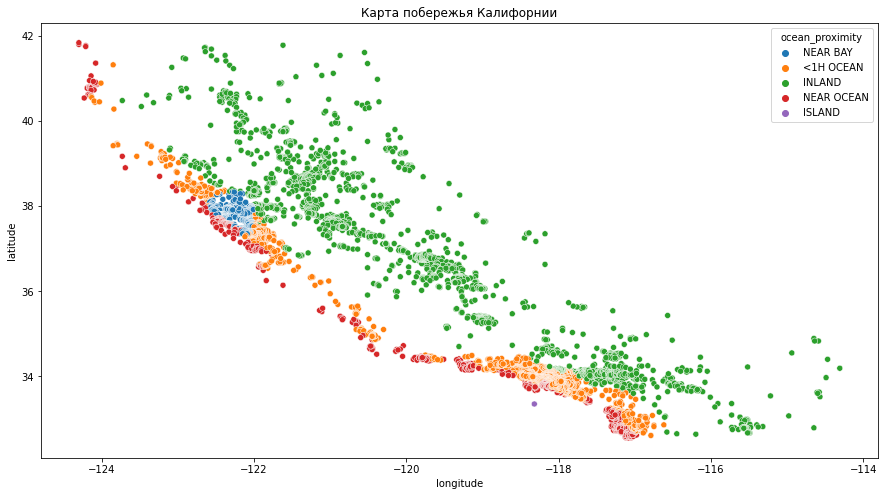

In [18]:
plot_california_coast(df_housing, 'ocean_proximity', 0.4)

Как и показала диаграмма распределенее ранее - сущестуют два густонаселенных района Калифорнии: на северо-западе рядом с заливом (NEAR BAY) и на юге побережья на расстоянии меньше часа езды от океана (<1H OCEAN)

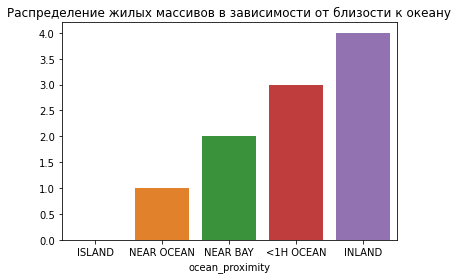

In [19]:
df_wealthy = df_housing.groupBy('ocean_proximity').count().toPandas()

sns.barplot(x=df_wealthy['ocean_proximity'], y= df_wealthy.index).set( 
    title="Распределение жилых массивов в зависимости от близости к океану")
pass

В основном, жилые массивы расположены во внутренних районах Калифорнии, а также на расстоянии часа езды от океана

**Зависимость возраста домов от удалённости жилого массива от океана** 

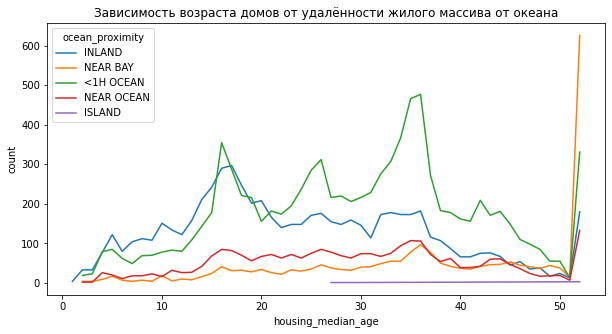

In [20]:
df_ages = df_housing.groupby('housing_median_age','ocean_proximity').count().toPandas()

plt.figure(figsize=(10,5))
sns.lineplot(data=df_ages, 
    x='housing_median_age', 
    y='count',
    hue='ocean_proximity'
).set( 
    title="Зависимость возраста домов от удалённости жилого массива от океана")
pass

По графику можно заметить, что новые жилые кварталы (возраст здания до 20 лет) находятся, в основном, в материковой части Калифорнии (INLAND) и в радиусе часа езды до океана. Более старые дома в радиусе часа езды до океана и около залива.

**На каком расстоянии от океана предпочитают жить самые обеспеченные люди** 

Для начала определим диапозон дохода и создадим временный признак с низким, средним и высоким доходом для более четкого отображения признака на диаграмме рассеивания

По разделению на квантили создам временную категорию медианного дохода жителей Калифорнии

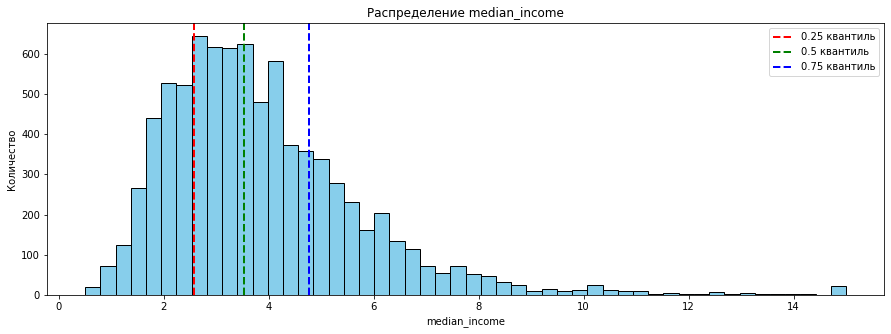

0.25, 0.5 и 0.75 квантили: [2.5687, 3.5313, 4.7625]


In [21]:
plot_distrib(df_housing, 'median_income')

видно, что люди с высоким уровнем дохода распределены гораздо более неравномерно.

In [22]:
#создаю временную категорию
df_housing = df_housing.withColumn('category_income', 
                                   when((df_housing.median_income <= 2.56), lit("low")).
                                   when((df_housing.median_income >= 4.75), lit("high")).
                                   otherwise(lit("medium")))

df_housing.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: integer (nullable = true)
 |-- total_rooms: integer (nullable = true)
 |-- population: integer (nullable = true)
 |-- households: integer (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)
 |-- total_bedrooms: integer (nullable = true)
 |-- category_income: string (nullable = false)



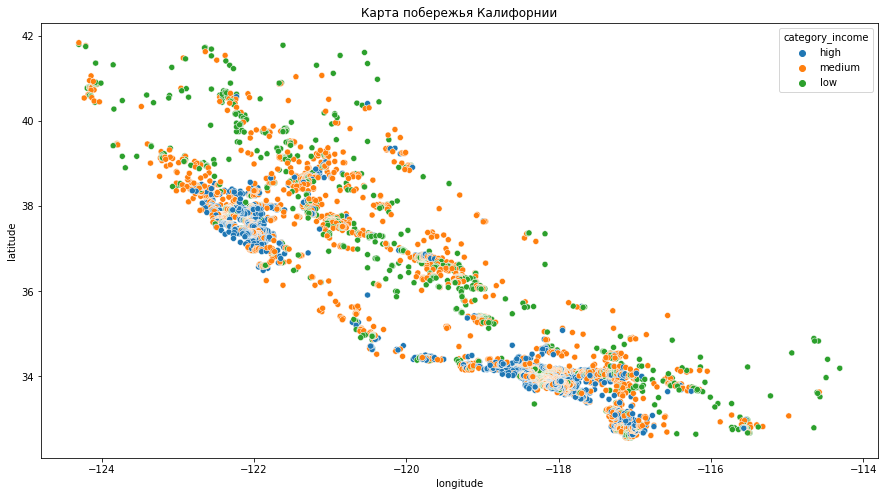

In [23]:
plot_california_coast(df_housing, 'category_income', 0.4)

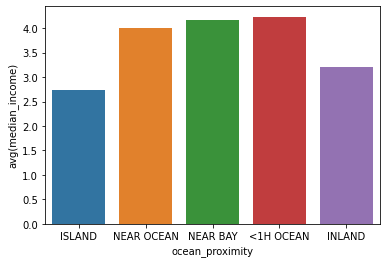

In [24]:
df_wealthy = df_housing.groupBy('ocean_proximity').agg(F.avg('median_income')).toPandas()
sns.barplot(x=df_wealthy['ocean_proximity'], y= df_wealthy['avg(median_income)'])
pass

Люди с высоким доходом предпочитают селиться в жилых массивах, которые находятся не более чем в часе езды до океана или около залива

In [25]:
#удалю временную категорию
df_housing = del_column(['category_income'], df_housing)

**Распределение медианной стоимости дома**

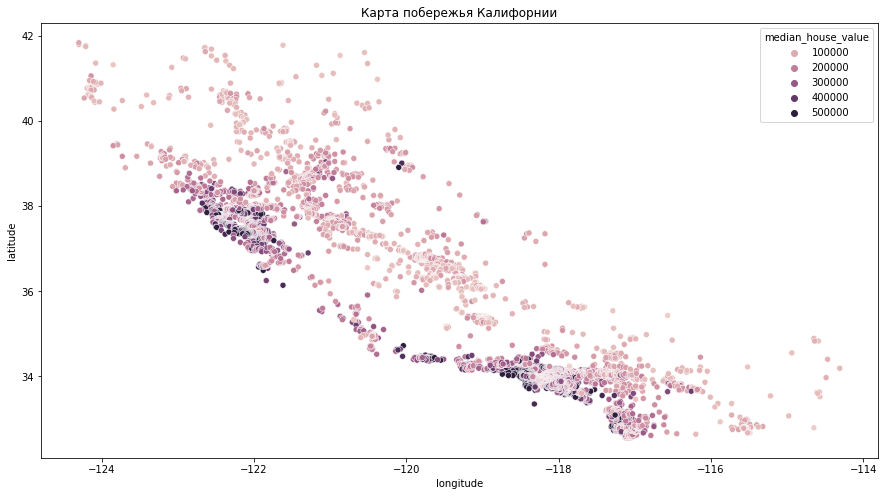

In [26]:
plot_california_coast(df_housing, 'median_house_value', 0.4)

Ожидаемый результат: люди с высоким доходом предпочитают селиться в самых дорогих жилых массивах

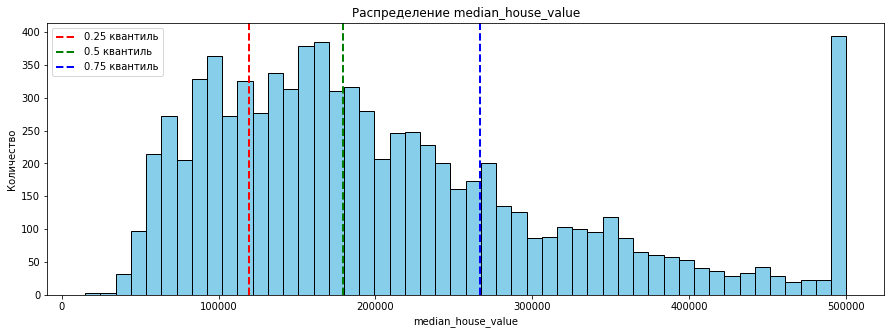

0.25, 0.5 и 0.75 квантили: [119300.0, 179500.0, 266700.0]


In [27]:
plot_distrib(df_housing, 'median_house_value')

Медианная стоимость домов распределена более равномерно, чем уровень дохода жителей
Как я и написала ранее, видно, что, в основном, медианная стоимость домов распределена нормально с перекосом вправо: по мере увеличения стоимости домов их количество уменьшается, за исключением того, что на пиковой стоимости количество резко возрастает.

In [28]:
df_housing.groupBy('median_house_value').count().orderBy('count', ascending = False).show(3)

+------------------+-----+
|median_house_value|count|
+------------------+-----+
|          500001.0|  965|
|          137500.0|  122|
|          162500.0|  117|
+------------------+-----+
only showing top 3 rows



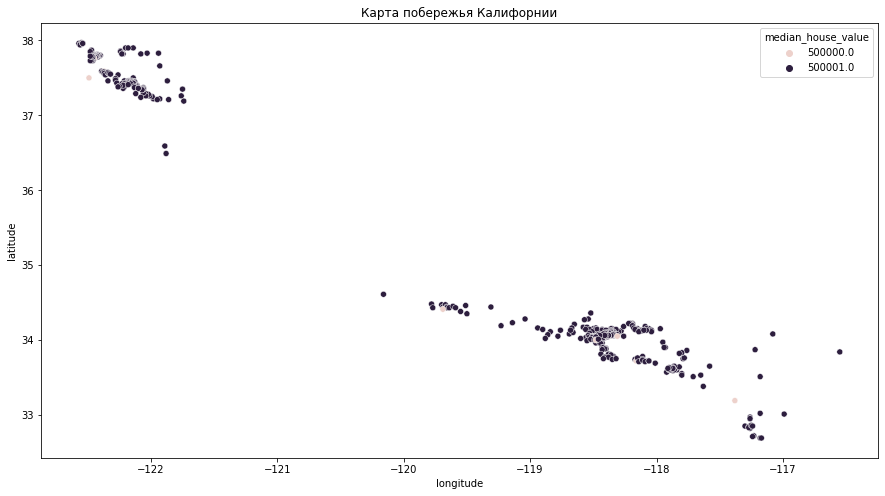

In [29]:
plot_california_coast(df_housing.filter('median_house_value > 499500'), 'median_house_value', 0.4)

Медианная стоимость домов в жилом массиве идентична для 958 случаев и равна максимальному значению для фрейма данных. Наиболее дорогостоящие дома расположены близко друг к другу и занимают два самых густонаселенных района Калифорнии

### Вывод

- Признак ocean_proximity (близость к океану) категориальный, остальные численные
- Для признаков housing_median_age, total_rooms, total_bedrooms,  population, households тип данных заменен на integer
- В датафрейме пропущен 1% данных - это 207 значений в признаке количества спален. Для заполнения пропусков использовался класс Imputer. 


- Жилые дома расположены на широте в диапозоне от -124.35 до -114.31, и на долготе от 32.54 до 41.95
- В основном, жилые массивы расположены во внутренних районах Калифорнии, а также на расстоянии часа езды от океана
- Существуют два густо населенных района штата: на северо-западе рядом с заливом (NEAR BAY) и на юге побережья на расстоянии меньше часа езды от океана (<1H OCEAN), в последнем расположены самые дорогостоящие дома.


- Средний медианный возраст домов живого массива 29 лет
- Медианный возраст домов жилого массива распределен нормально, за исключением трех доминирующих возрастов: около 16, 35 и 50 лет, вероятно, в те года были массовые застройки
- Новые жилые кварталы (возраст здания до 20 лет) находятся, в основном, в материковой части Калифорнии (INLAND) и в радиусе часа езды до океана. Более старые дома в радиусе часа езды до океана и около залива.


- В данных присутствуют как частные дома, так и многоквартирные. В основном, дома многоквартирные.
- Общее количества комнат, спален, проживающих в жилом массиве и домовладельцев распределено практически экспоненциально со снижением распространенности по мере нарастания признака, что естественно для данных значений


- Медианный доход варируется от 5 до 150 тысяч доларов 
- Люди с высоким доходом предпочитают селиться в жилых массивах, которые находятся не более чем в часе езды до океана или около залива, и ожидаемо - в самых дорогих жилых массивах


- Медианная стоимость дома в жилом массиве в пределах 14.999-500 001 долларов, в среднем 179.7 тыс. долларов.
- В основном, медианная стоимость домов распределена нормально с перекосом вправо: по мере увеличения стоимости домов их количество уменьшается, но на пиковой стоимости резко возрастает. Многочисленность домов со стоимостью около 500тыс. долларов, связано с тем, что рассчет в данных прозведен по мединной стоимости домов в жилом массиве, а наиболее дорогостоящие дома расположены близко друг к другу и занимают два самых густонаселенных района Калифорнии. 

## Проверка на мультиколлинеарность

Ситуация мультиколлинеарности возникает, когда две независимые переменные имеют сильную корреляцию.

Поскольку существует сильная взаимосвязь, определение значимых переменных будет сложной задачей. Может произойти переобучение, и точность модели изменится в зависимости от набора данных.

Для проверки на мульколлинеарность я буду использовать корреляцию Спирмена.

Корреляция Спирмена (Spearman correlation): Это непараметрический метод, который измеряет связь между переменными на основе рангов значений. Он подходит для измерения любого типа монотонной связи, даже если она не является линейной.

Для расчета корреляции в PySpark копиую дафрейм, так как необходимо, чтобы все переменные имели тип данных integer

root
 |-- longitude: integer (nullable = true)
 |-- latitude: integer (nullable = true)
 |-- housing_median_age: integer (nullable = true)
 |-- total_rooms: integer (nullable = true)
 |-- population: integer (nullable = true)
 |-- households: integer (nullable = true)
 |-- median_income: integer (nullable = true)
 |-- median_house_value: integer (nullable = true)
 |-- ocean_proximity: string (nullable = true)
 |-- total_bedrooms: integer (nullable = true)



24/01/18 16:42:18 WARN Executor: Managed memory leak detected; size = 5244608 bytes, TID = 1280
24/01/18 16:42:20 WARN Executor: Managed memory leak detected; size = 5244608 bytes, TID = 1282
24/01/18 16:42:21 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
24/01/18 16:42:21 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


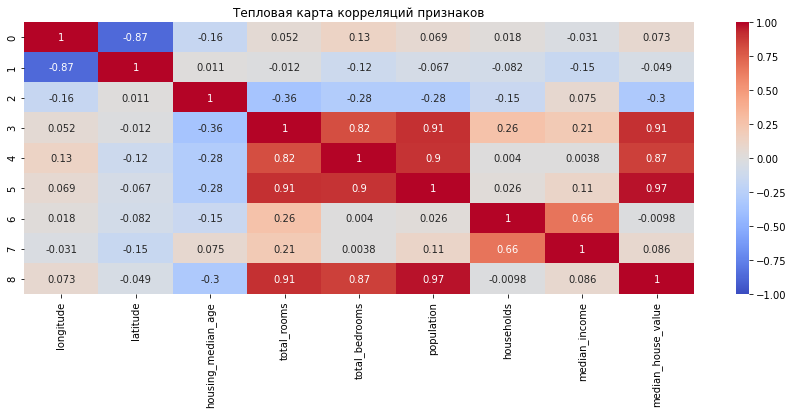

In [30]:
#копирую датасет
correlations = df_housing.select('*')
#изменяю тип данных
correlations = correlations.withColumn('longitude', F.col('longitude').cast(IntegerType()))
correlations = correlations.withColumn('latitude', F.col('latitude').cast(IntegerType()))
correlations = correlations.withColumn('median_income', F.col('median_income').cast(IntegerType()))
correlations = correlations.withColumn('median_house_value', F.col('median_house_value').cast(IntegerType()))
correlations.printSchema()

columns = ['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value']

corr(columns, correlations)

Есть несколько сильно кррелирующих пар признаков:
- `longitude` - `latitude` (-0.87)

- `total_rooms` - `total_bedrooms` (0.82)
- `total_rooms` - `population` (0.91)

- `total_bedrooms` - `population` (0.9)

Для того, чтобы сохранить информацию из коррелирующих признаках, но уменьшить корееляцию - созданы несколько новых столбцов с признаками: 

- Отношение количества комнат `total_rooms` к количеству домовладений `households`. Колонка `rooms_per_household`.
- Отношение количества жителей `population` к количеству домовладений `households`. Колонка `population_in_household`.
- Отношение количества спален `total_bedrooms` к общему количеству комнат `total_rooms`. Колонка `bedroom_index`.


- Удалю сначала только признак `longitude`, затем и `latitude` и посмотрю, как данные изменения повлияют в будущем на метрику при построении модели ML
- Удалю изначальные коррелирующие признаки

In [31]:
# создание новых столбцов
df_housing = df_housing.withColumn('rooms_per_household', F.col('total_rooms')/F.col('households'))
df_housing = df_housing.withColumn('population_in_household', F.col('population')/F.col('households'))
df_housing = df_housing.withColumn('bedroom_index', F.col('total_bedrooms')/F.col('total_rooms'))

#удаление сильнокоррелирующих признаков
df_housing = del_column(['longitude',  'total_rooms', 'population'], df_housing)

df_housing.printSchema()

root
 |-- latitude: double (nullable = true)
 |-- housing_median_age: integer (nullable = true)
 |-- households: integer (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)
 |-- total_bedrooms: integer (nullable = true)
 |-- rooms_per_household: double (nullable = true)
 |-- population_in_household: double (nullable = true)
 |-- bedroom_index: double (nullable = true)



### Вывод

1. В процессе рассчета корреляции были определены сильнокоррелирующие пары признаков:
- `longitude` - `latitude` (-0.87)

- `total_rooms` - `total_bedrooms` (0.82)
- `total_rooms` - `population` (0.91)

- `total_bedrooms` - `population` (0.9)
- `total_bedrooms` - `households` (0.97)

2. Для того, чтобы сохранить информацию из коррелирующих признаках без снижения производительности модели - были созданы новые синтетические признаки:

- Отношение количества комнат `total_rooms` к количеству домовладений `households`. Колонка `rooms_per_household`.
- Отношение количества жителей `population` к количеству домовладений `households`. Колонка `population_in_household`.
- Отношение количества спален `total_bedrooms` к общему количеству комнат `total_rooms`. Колонка `bedroom_index`.

После внесенных изменений сильная корреляция между признаками отсутствуют

3. Изначальные коррелирующие признаки удалены, за исключением пары `longitude`-`latitude`. Было решено в дальнейшем проверить как наличие одного из признаков или отсутствие обоих может повлиять на результаты модели


4. Категориальный признак `ocean_proximity` не участвовал в проверке на мультиколлинеарность

## Отбор набора обучающих признаков

Для построения модели линейной регрессии будут выбраны два набора данных:

- с использованием всех данных из файла;
- с использованием только числовых переменных.

Также я проверю как наличие одного из признаков координат (ширины и долготы) или отсутствие обоих может повлиять на результаты модели.

In [32]:
#фрейм с с использованием всех данных
df1 = df_housing.select('*')

## Обучение моделей

Для построения модели будет использоваться LinearRegression и GBTRegressor из модуля MLlib

С помощью pipline будет создана последовательность из пяти трансформаций:
    
1. **StringIndexer**: используется для преобразования категориальных признаков в числовые значения. Он присваивает каждому уникальному значению в категориальном столбце уникальный числовой индекс.

2. **OneHotEncoder**: используется для преобразования числовых индексов, созданных StringIndexer, в разреженные векторы. Каждый уникальный индекс преобразуется в вектор с единицей в позиции, соответствующей индексу, и нулями во всех остальных позициях.

3. **VectorAssembler**: используется для объединения всех признаков в один вектор. Он принимает входные столбцы, созданные предыдущими преобразованиями, и создает новый столбец, содержащий вектор с данными из всех входных столбцов.

4. **StandardScaler**: метод, который помогает нормализовать эти числовые признаки, чтобы они имели одинаковое среднее значение и дисперсию. Это делается для того, чтобы алгоритмы машинного обучения работали более эффективно и точно

5. **LinearRegression**: Это модель линейной регрессии, которая используется для предсказания целевой переменной на основе входных признаков. Она подстраивается под данные, чтобы найти наилучшие значения коэффициентов для линейной комбинации признаков.

ИЛИ 5. **GBTRegressor:** Это модель градиентного бустинга деревьев регрессии, которая используется для предсказания целевой переменной на основе входных признаков. Она работает путем комбинирования нескольких слабых моделей, таких как деревья решений, и улучшает свою точность постепенно. GBTRegressor подстраивается под данные, минимизируя функцию потерь при обучении каждого дерева, и объединяет прогнозы всех деревьев для получения окончательного предсказания. 

Pipeline объединяет все эти компоненты в цепочку, в которой данные последовательно проходят через каждый этап преобразования. Это позволяет легко применять все преобразования к данным и обучать модель на преобразованных данных.

Для сравнения результатов работы линейной регрессии будут использоатья метрики RMSE, MAE и R2

По итогу, я создам и сравню 12 моделей: модели LR и GBT с использованием всех данных, с использованием только численных признаков, а также определю как наличие одного из признаков - широты и долготы -  или отсутствие обоих может повлиять на результаты моделей.
Сохраню только ключевой рассчет обучения четырех моделей с использованием или отсутствием категориальных признаков, а для изучения влияния координат я буду менять код по ходу работы и сохраню только результат вычесления метрик в выводе. 

In [33]:
df1.columns

df1 = df1.withColumn('median_house_value', F.col('median_house_value').cast(IntegerType()))

In [34]:
#категориальные признаки
cat_cols = ['ocean_proximity']

#численные признаки
num_cols =  ['latitude',
             'households',
             'housing_median_age',
             'median_income',
             'rooms_per_household',
             'population_in_household',
             'bedroom_index']

target = ['median_house_value']

### LinearRegression

#### Обучение с использованием всех данных

In [35]:
# Создание объекта StringIndexer для преобразования категориальных признаков
string_indexer = StringIndexer(inputCols=cat_cols,
                               outputCols=[f"indexed_{col}" for col in cat_cols],
                               handleInvalid="skip")

# Создание объекта OneHotEncoder для преобразования индексированных признаков в векторы
one_hot_encoder = OHE(inputCols=[f"indexed_{col}" for col in cat_cols],
                               outputCols=[f"encoded_{col}" for col in cat_cols])

# Создание объекта VectorAssembler для объединения всех признаков в один вектор
vector_assembler = VectorAssembler(inputCols=[f"encoded_{col}" for col in cat_cols] + num_cols,
                                  outputCol="unscaled_features")

# Создание объекта StandardScaler для стандартизации признаков
scaler = StandardScaler(inputCol="unscaled_features", outputCol="scaled_features")

# Создание объекта LinearRegression для построения модели линейной регрессии
lr = LinearRegression(featuresCol="scaled_features", labelCol=target[0], regParam=0.01)

# Создание pipeline для df1, включающего все преобразования и модель
pipeline_1 = Pipeline(stages=[string_indexer, one_hot_encoder, vector_assembler, scaler, lr])

In [36]:
# Разделение данных на обучающую и тестовую выборки
(data_train, data_test) = df1.randomSplit([0.7, 0.3], seed=RANDOM_SEED)

In [37]:
# Обучение модели с использованием pipeline
model_1 = pipeline_1.fit(data_train)

# Прогнозирование на тестовых данных
predictions = model_1.transform(data_test)

pred(predictions, 'prediction')

24/01/18 16:42:29 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
24/01/18 16:42:29 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


Root Mean Squared Error (RMSE) на тестовых данных = 73350.8
Mean Absolute Error (MAE) на тестовых данных = 52688.1
R2 на тестовых данных = 0.605823


1. С использованием признака `latitude`:

- Root Mean Squared Error (RMSE) на тестовых данных = **72450**
- Mean Absolute Error (MAE) на тестовых данных = **52191**
- R2 на тестовых данных = **0.607**

2. С использованием признака `longitude`:

- Root Mean Squared Error (RMSE) на тестовых данных = **73179**
- Mean Absolute Error (MAE) на тестовых данных = **52629**
- R2 на тестовых данных = **0.613**

3. Без использования признаков `latitude` и`longitude`:

- Root Mean Squared Error (RMSE) на тестовых данных = **70477**
- Mean Absolute Error (MAE) на тестовых данных = **51225**
- R2 на тестовых данных = **0.629**

#### Обучение без категориальных признаков 

In [38]:
vector_assembler_2 = VectorAssembler(inputCols=num_cols,
                                   outputCol="unscaled_features")

# Создание pipeline для df1, включающего все преобразования и модель
pipeline_2 = Pipeline(stages=[vector_assembler_2, imputer, scaler, lr])

# Обучение модели с использованием pipeline
model_2 = pipeline_2.fit(data_train)

# Прогнозирование на тестовых данных
predictions = model_2.transform(data_test)

pred(predictions, 'prediction')

Root Mean Squared Error (RMSE) на тестовых данных = 79448.5
Mean Absolute Error (MAE) на тестовых данных = 57333.3
R2 на тестовых данных = 0.537563


1. С использованием признака `latitude`:

- Root Mean Squared Error (RMSE)  = **78032**
- Mean Absolute Error (MAE) = **57652**
- R2 на тестовых данных = **0.544**

2. С использованием признака `longitude`: 

- Root Mean Squared Error (RMSE) на тестовых данных = **79185**
- Mean Absolute Error (MAE) на тестовых данных = **57726**
- R2 на тестовых данных = **0.547**

3. Без использования признаков `latitude` и `longitude`:

- Root Mean Squared Error (RMSE) на тестовых данных = **76188**
- Mean Absolute Error (MAE) на тестовых данных = **56351**
- R2 на тестовых данных = **0.566**

### GBTRegressor

#### Обучение с использованием всех данных

In [39]:
# Создание объекта GBTRegressor для построения модели градиентного бустинга
gbt = GBTRegressor(featuresCol="scaled_features", labelCol=target[0], maxDepth=5, maxIter=20, seed=12345)

# Создание pipeline для df1, включающего все преобразования и модель
pipeline_3 = Pipeline(stages=[string_indexer, one_hot_encoder, vector_assembler,imputer, scaler, gbt])

# Обучение модели с использованием pipeline
model_3 = pipeline_3.fit(data_train)

# Прогнозирование на тестовых данных
predictions = model_3.transform(data_test)

pred(predictions, 'prediction')

Root Mean Squared Error (RMSE) на тестовых данных = 59993
Mean Absolute Error (MAE) на тестовых данных = 41665.9
R2 на тестовых данных = 0.736317


1. С использованием признака `latitude`:

- Root Mean Squared Error (RMSE)  = **58510**
- Mean Absolute Error (MAE) = **41159**
- R2 на тестовых данных = **0.74**

2. С использованием признака `longitude`:

- Root Mean Squared Error (RMSE) на тестовых данных = **59091**
- Mean Absolute Error (MAE) на тестовых данных = **41146**
- R2 на тестовых данных = **0.75**

3. Без использования признаков `latitude` и `longitude`:

- Root Mean Squared Error (RMSE) на тестовых данных = **60532**
- Mean Absolute Error (MAE) на тестовых данных = **43164**
- R2 на тестовых данных = **0.72**

#### Обучение без категориальных признаков 

In [40]:
# Создание pipeline для df1, без категориальных признаков и модель
pipeline_4 = Pipeline(stages=[vector_assembler_2, imputer, scaler, gbt])

# Обучение модели с использованием pipeline
model_4 = pipeline_4.fit(data_train)

# Прогнозирование на тестовых данных
predictions = model_4.transform(data_test)

pred(predictions, 'prediction')

Root Mean Squared Error (RMSE) на тестовых данных = 64939.5
Mean Absolute Error (MAE) на тестовых данных = 46001.8
R2 на тестовых данных = 0.691042


1. С использованием признака `latitude`:

- Root Mean Squared Error (RMSE)  = **63261**
- Mean Absolute Error (MAE) = **45182**
- R2 на тестовых данных = **0.70**

2. С использованием признака `longitude`:

- Root Mean Squared Error (RMSE) на тестовых данных = **64914**
- Mean Absolute Error (MAE) на тестовых данных = **46005**
- R2 на тестовых данных = **0.70**

3. Без использования признаков `latitude` и `longitude`:

- Root Mean Squared Error (RMSE) на тестовых данных = **66236**
- Mean Absolute Error (MAE) на тестовых данных = **47885**
- R2 на тестовых данных = **0.67**

### Определение лучшей модели

- Хорошая модель обладает низкими значениями RMSE и MAE, что означает, что ее предсказания близки к фактическим значениям. 
- Кроме того, хорошая модель имеет высокое значение R2, что означает, что она хорошо объясняет изменчивость целевой переменной.

In [41]:
#таблица основных показателей
recap_lr = {'RMSE':[72450,  73179, 70477, 78032, 79185, 76188],
         'MAE':[52191, 52629, 51225, 57652, 57726, 56351],
         'R2':[0.607, 0.613, 0.629, 0.544, 0.547, 0.566]} 

recap_gbt = {'RMSE':[58510,  59091, 60532, 63261, 64914, 66236],
         'MAE':[41159, 41146, 43164, 45182, 46005, 47885],
         'R2':[0.74, 0.75, 0.72, 0.70, 0.70, 0.67]} 


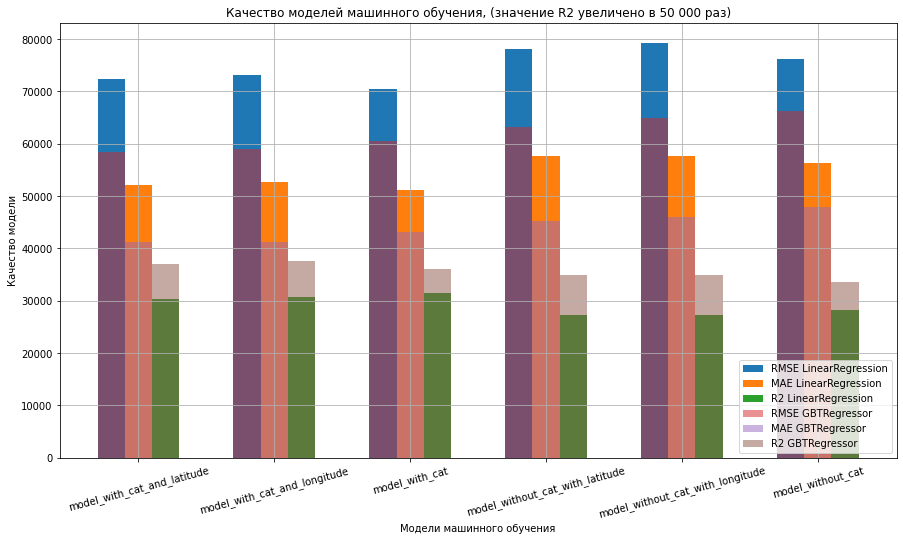

Качество моделей машинного обучения LinearRegression


,RMSE,MAE,R2
model_with_cat,70477,51225,0.629
model_with_cat_and_latitude,72450,52191,0.607
model_with_cat_and_longitude,73179,52629,0.613
model_without_cat,76188,56351,0.566
model_without_cat_with_latitude,78032,57652,0.544
model_without_cat_with_longitude,79185,57726,0.547


Качество моделей машинного обучения GBTRegressor


,RMSE,MAE,R2
model_with_cat_and_latitude,58510,41159,0.74
model_with_cat_and_longitude,59091,41146,0.75
model_with_cat,60532,43164,0.72
model_without_cat_with_latitude,63261,45182,0.70
model_without_cat_with_longitude,64914,46005,0.70
model_without_cat,66236,47885,0.67


In [42]:
# Преобразование recap в DataFrame с настраиваемыми индексами
recap1 = pd.DataFrame(recap_lr, index =['model_with_cat_and_latitude',
                                      'model_with_cat_and_longitude',
                                      'model_with_cat',
                                      'model_without_cat_with_latitude',
                                      'model_without_cat_with_longitude',
                                      'model_without_cat'])
recap2 = pd.DataFrame(recap_gbt, index =['model_with_cat_and_latitude',
                                      'model_with_cat_and_longitude',
                                      'model_with_cat',
                                      'model_without_cat_with_latitude',
                                      'model_without_cat_with_longitude',
                                      'model_without_cat'])

# Сортировка DataFrame recap1 и recap2 на основе значений RMSE, MAE и R2.
sorted_recap1 = recap1.sort_values(by=['RMSE', 'MAE', 'R2'], ascending=[True, True, False])
sorted_recap2 = recap2.sort_values(by=['RMSE', 'MAE', 'R2'], ascending=[True, True, False])

# Построение гистограммы
fig = plt.figure(figsize=(15, 8))
X = recap1.index
X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, recap1['RMSE'], 0.2, label='RMSE LinearRegression')
plt.bar(X_axis, recap1['MAE'], 0.2, label='MAE LinearRegression')
plt.bar(X_axis + 0.2, recap1['R2']*50000, 0.2, label='R2 LinearRegression')

plt.bar(X_axis - 0.2, recap2['RMSE'], 0.2, label='RMSE GBTRegressor', alpha=0.5)
plt.bar(X_axis, recap2['MAE'], 0.2, label='MAE GBTRegressor', alpha=0.5)
plt.bar(X_axis + 0.2, recap2['R2']*50000, 0.2, label='R2 GBTRegressor', alpha=0.5)

plt.xticks(X_axis, X, rotation=15)
plt.xlabel("Модели машинного обучения")
plt.ylabel("Качество модели")
plt.title('Качество моделей машинного обучения, (значение R2 увеличено в 50 000 раз)')
plt.grid()
plt.legend(loc='lower right')
plt.show()

print('Качество моделей машинного обучения LinearRegression')
display(sorted_recap1)
print('Качество моделей машинного обучения GBTRegressor')
display(sorted_recap2)

- Лучашя модель LinearRegression: с использованием категориального признака `ocean_proximity` (близость к океану) без признаков координат, метрики:

  - Root Mean Squared Error (RMSE) на тестовых данных = **70477**
  - Mean Absolute Error (MAE) на тестовых данных = **51225**
  - R2 на тестовых данных = **0.629**

- Лучашя модель GBTRegressor: с использованием категориального признака `ocean_proximity` (близость к океану) и с признаком `latitude` (долгота), метрики:
  - Root Mean Squared Error (RMSE)  = **58510**
  - Mean Absolute Error (MAE) = **41159**
  - R2 на тестовых данных = **0.74**

- Модель GBTRegressor показала лучший результат по сравнению с LinearRegression

### Grid Search с лучшей моделью

Попробую улучшить метрики, добавив перебор гиперпараметров для лучшей модели

Гиперпараметры, которые входят в param_grid:

1. **maxDepth**: определяет максимальную глубину дерева решений.
2. **maxBins**: определяет максимальное количество корзин (bins) для категориальных признаков.
3. **maxIter**: определяет максимальное количество итераций (эпох) для обучения модели градиентного бустинга.
4. **gbt.stepSize**: отвечает за размер шага при обучении модели. 
5. **gbt.subsamplingRate**: определяет долю обучающих данных, используемых для каждого дерева в ансамбле. Значения [0.5, 0.75, 1.0] указывают на то, что модель будет обучаться на разных долях обучающих данных: 50%, 75% и 100%.
6. **gbt.minInstancesPerNode**: Эопределяет минимальное количество экземпляров, которое должно находиться в узле дерева, чтобы продолжить деление этого узла
7. **gbt.seed**: Этот параметр устанавливает начальное значение для генератора случайных чисел. 

Эти гиперпараметры используются для настройки модели градиентного бустинга (GBT) с помощью метода кросс-валидации и поиска оптимальных значений для каждого гиперпараметра.

In [43]:
#evaluator = RegressionEvaluator(labelCol=target[0], predictionCol="prediction", metricName="rmse")

# Создание объекта Grid Search с параметрами для настройки модели
#param_grid = ParamGridBuilder() \
#    .addGrid(gbt.maxDepth, [2, 5, 10]) \
#    .addGrid(gbt.maxBins, [10, 20, 30]) \
#    .addGrid(gbt.maxIter, [10, 50, 100, 250, 500, 750, 1000]) \
#    .addGrid(gbt.seed, [12345]) \
#    .build()

# Создание объекта CrossValidator для кросс-валидации с Grid Search
#cross_validator = CrossValidator(estimator=pipeline_3,
#                                 estimatorParamMaps=param_grid,
#                                 evaluator=evaluator,
#                                 numFolds=3)

# Обучение модели с использованием CrossValidator
#cv_model = cross_validator.fit(data_train)

# Получение всех моделей и их оценок
#all_models = cv_model.avgMetrics

# Поиск индекса модели с наименьшим значением RMSE
#best_model_index = all_models.index(min(all_models))

# Получение лучшей модели и ее гиперпараметров
#best_model = cv_model.bestModel
#best_rmse = all_models[best_model_index]

# Прогнозирование на тестовых данных с использованием лучшей модели
#predictions = best_model.transform(data_test)

# Вывод лучшей модели и ее гиперпараметров
#print("Лучшая модель:")
#print("RMSE =", best_rmse)
#print("maxDepth =", best_model.stages[-1].getMaxDepth())
#print("maxBins =", best_model.stages[-1].getMaxBins())
#print("maxIter =", best_model.stages[-1].getMaxIter())

# Прогнозирование на тестовых данных с использованием лучшей модели
#predictions = best_model.transform(data_test)

# Прогнозирование на тестовых данных с использованием лучшей модели
#predictions = best_model.transform(data_test)

# Вывод предсказаний
#predictions.select('prediction').show()

Лучшая модель:
RMSE = 59432.32970895537
maxDepth = 5
maxBins = 32
maxIter = 20
stepSize = 0.1
subsamplingRate = 1.0
minInstancesPerNode = 1

Использование Grid Search не изменило метрики модели

## Анализ результатов

In [44]:
# Получение объекта модели из лучшей модели
model = model_3.stages[-1]

# Получение важности признаков
feature_importances = model.featureImportances

# Получение списка названий признаков
feature_names = data_train.drop('median_house_value').columns

# Создание словаря с важностью признаков
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Сортировка признаков по убыванию важности
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Вывод результатов
print("Важность признаков:")
for feature, importance in sorted_features:
    print(feature, "=", importance)


Важность признаков:
population_in_household = 0.3257000386297269
ocean_proximity = 0.1875250849463887
housing_median_age = 0.0986691209554643
rooms_per_household = 0.08212142044183994
bedroom_index = 0.04599188322365019
total_bedrooms = 0.037886294478221914
households = 0.023347527120236
median_income = 0.014066735433928942
latitude = 0.006342063362797163


Модель определяла медианную стоимость дома в жилом массиве, в основном, по таким признакам как:
- population_in_household  (отношение количества жителей к количеству домовладений)
- ocean_proximity  (близость к океану)
- housing_median_age (медианный возраст жителей жилого массива)
- rooms_per_household  (отношение количества комнат к количеству домовладений)
- bedroom_index (отношение количества спален total_bedrooms к общему количеству комнат)

- наименьшее значение у признаков median_income (медианный доход жителей жилого массива) и latitude (долгота)

In [45]:
spark.stop()

## Отчет по исследованию

**1. Инициализирована локальная Spark-сессия**

**2. Проведена предобработка и исследование данных:**


- Выявлено, что признак ocean_proximity (близость к океану) категориальный, остальные численные
- Для признаков housing_median_age, total_rooms, total_bedrooms,  population, households тип данных заменен на integer
- В датафрейме пропущен 1% данных - пропуски в total_bedrooms (общее количество спален в домах жилого массива). Для заполнения пропусков использовался класс Imputer.

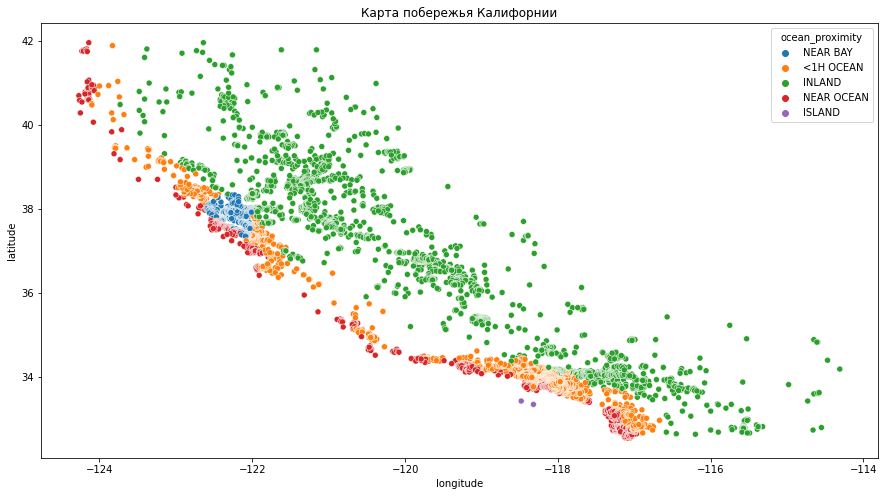 
- Основные жилые массивы находятся во внутренних районах Калифорнии и на расстоянии часа езды от океана.
- Существуют два густонаселенных района: на северо-западе рядом с заливом (NEAR BAY) и на южном побережье в радиусе менее часа езды от океана (<1H OCEAN), в последних расположены самые дорогостоящие дома.


- Средний медианный возраст домов в жилых массивах составляет 29 лет.
- Распределение медианного возраста домов в жилых массивах нормальное, с тремя пиками возраста около 16, 35 и 50 лет. Это может указывать на массовую застройку в эти годы.
- Новые жилые кварталы (возраст здания до 20 лет) в основном находятся в материковой части Калифорнии (INLAND) и в радиусе часа езды до океана. Более старые дома находятся также в радиусе часа езды до океана и около залива.


- В данных присутствуют как частные дома, так и многоквартирные. Однако в основном преобладают многоквартирные дома.
- Распределение общего количества комнат, спален, проживающих в жилом массиве и домовладельцев практически экспоненциальное, с уменьшением распространенности по мере увеличения значения признака.


- Медианный доход варьируется от 5 до 150 тысяч долларов.
- Люди с высоким доходом предпочитают жить в жилых массивах, находящихся в пределах часа езды до океана или около залива. Самые дорогостоящие жилые массивы также привлекают людей с высоким доходом.


- Медианная стоимость дома в жилом массиве в пределах 14.999-500 001 долларов, в среднем 179.7 тыс. долларов.
- В основном, медианная стоимость домов распределена нормально с перекосом вправо: по мере увеличения стоимости домов их количество уменьшается, но на пиковой стоимости резко возрастает. 
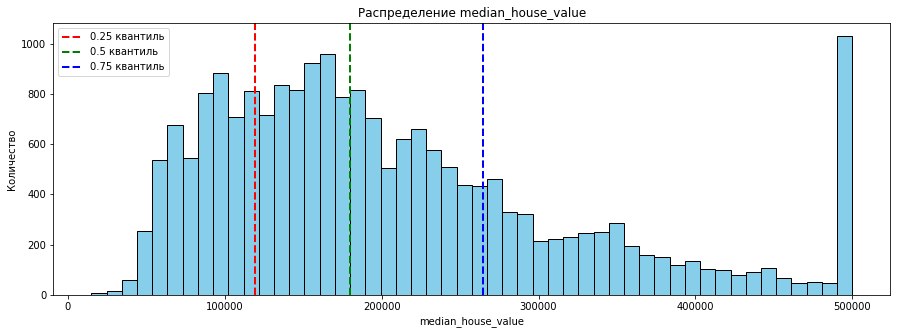

- Предобработка и исследование данных проведены с использованием методов pySpark

**3. Проверка на мультиколлинеарность:**
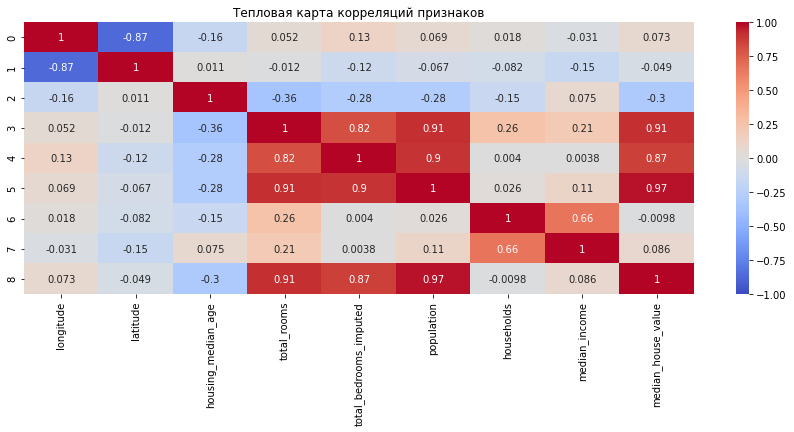
3.1. В процессе рассчета корреляции были определены сильнокоррелирующие пары признаков:
- `longitude` - `latitude` (-0.87)

- `total_rooms` - `total_bedrooms` (0.82)
- `total_rooms` - `population` (0.91)

- `total_bedrooms` - `population` (0.9)

3.2. Для того, чтобы сохранить информацию из коррелирующих признаках без снижения производительности модели - были созданы новые синтетические признаки:

- Отношение количества комнат `total_rooms` к количеству домовладений `households`. Колонка `rooms_per_household`.
- Отношение количества жителей `population` к количеству домовладений `households`. Колонка `population_in_household`.
- Отношение количества спален `total_bedrooms` к общему количеству комнат `total_rooms`. Колонка `bedroom_index`.

3.3. Изначальные коррелирующие признаки удалены, за исключением пары `longitude`-`latitude`. Было решено в дальнейшем проверить как наличие одного из признаков или отсутствие обоих может повлиять на результаты модели

3.4. Категориальный признак `ocean_proximity` не участвовал в проверке на мультиколлинеарность

**4.  Отбор набора обучающих признаков**

Для построения модели линейной регрессии выбраны два набора данных:

- с использованием всех данных из файла;
- с использованием только числовых переменных.

Также проверено как наличие одного из признаков координат (ширины и долготы) или отсутствие обоих может повлиять на результаты модели.

**5. Обучение моделей**

Для построения модели использовались LinearRegression и GBTRegressor из модуля MLlib, пайплайн состоял из следующих трансформаций:

- StringIndexer: преобразование категориальных признаков в числовые значения.

- OneHotEncoder: преобразование числовых индексов в разреженные векторы.

- VectorAssembler: объединение всех признаков в один вектор.

- StandardScaler: нормализация числовых признаков.

- LinearRegression или GBTRegressor

Для оценки результатов применяются метрики RMSE, MAE и R2.

- Модель GBTRegressor показала лучший результат по сравнению с LinearRegression

- Модель LinearRegression показала лучшие результаты с использованием категориального признака `ocean_proximity` (близость к океану) без признаков координат. 

- Модель GBTRegressor - с использованием категориального признака `ocean_proximity` (близость к океану) и с признаком `latitude` (долгота), метрики лучшей модели:
  - Root Mean Squared Error (RMSE)  = **58510**
  - Mean Absolute Error (MAE) = **41159**
  - R2 на тестовых данных = **0.74**

- Модель GBTRegressor показала лучший результат по сравнению с LinearRegression
**6. Анализ результатов**

Модель определяла медианную стоимость дома в жилом массиве, в основном, по таким признакам как:
- population_in_household  (отношение количества жителей к количеству домовладений)
- ocean_proximity  (близость к океану)
- housing_median_age (медианный возраст жителей жилого массива)
- rooms_per_household  (отношение количества комнат к количеству домовладений)
- bedroom_index (отношение количества спален total_bedrooms к общему количеству комнат)

- наименьшее значение у признаков median_income (медианный доход жителей жилого массива) и latitude (долгота)